# Vector Autoregressive Fault Detection
VAR follows a 3-step process:
1. Check if the input time series is stationary
    * If a component is non-stationary, conduct a transformation to make it stationary
2. Fit an Ordinary-Least-Squares VAR model
3. Identify the _n_ points with the largest OLS residuals. These are the faults and/or changepoints.

In [12]:
#Import Packages

import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn import preprocessing

from statsmodels.tsa import stattools as st
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

import utils.evaluating
from utils.evaluating import evaluating_change_point

import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [13]:
#Load Files

all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

dfs=[]
for path in all_files:
    df = pd.read_csv(path,sep=';', index_col='datetime', parse_dates=True)
    # df['datetime'] = df['datetime'].apply(pd.to_datetime)
    dfs.append(df)
print('Features:')
for col in dfs[1].columns:
    print('\t',col)

col_names = list(dfs[1].columns[0:8])

Features:
	 Accelerometer1RMS
	 Accelerometer2RMS
	 Current
	 Pressure
	 Temperature
	 Thermocouple
	 Voltage
	 Volume Flow RateRMS
	 anomaly
	 changepoint


..\data\valve1\13.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,0.027546,0.040642,0.968501,0.047520,67.613386,24.580039,230.821466,30.028251,0.350000,0.003509
std,0.000373,0.000986,0.269974,0.259354,0.869162,0.017420,10.614452,3.770802,0.477179,0.059157
min,0.026283,0.037739,0.397457,-0.929070,65.392500,24.532400,204.082000,23.000000,0.000000,0.000000
25%,0.027301,0.039940,0.735012,0.054711,67.055000,24.570300,224.908500,24.947000,0.000000,0.000000
50%,0.027560,0.040658,0.979753,0.054711,67.877150,24.581350,231.090500,32.000000,0.000000,0.000000
75%,0.027818,0.041327,1.197797,0.054711,68.219875,24.590100,237.050250,32.971900,1.000000,0.000000
max,0.028727,0.043859,1.566110,0.710565,69.052100,24.630300,255.112000,33.000000,1.000000,1.000000


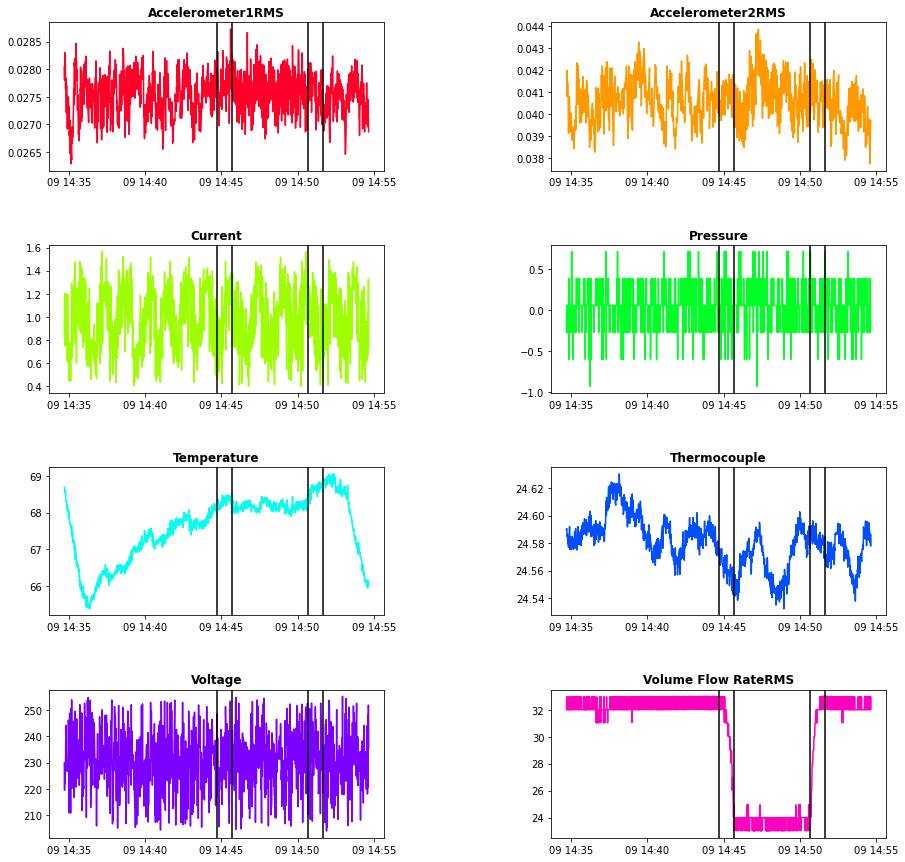

In [14]:
# Plot Data
experiments = [20]
for i in experiments:
    print(all_files[i].replace("/","\\"))
    display(dfs[i].describe())
    df = dfs[i]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    color = iter(cm.gist_rainbow(np.linspace(0, 1, len(df.columns)-2)))
    points = df.index[df['changepoint'] == 1].tolist()
    for col, ax in zip(df.columns[0:8], axes.flatten()):
        c = next(color)
        ax.set_title(col, fontweight="bold")
        ax.plot(df[col], c=c)
        for p in points:
            ax.axvline(p, color="black")
        plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.set_facecolor('white')
    fig.set_size_inches(15, 15)
    fig.savefig('Figure 1', bbox_inches="tight")

In [15]:
#Test Stationarity

def test_stationary(data, column='', signif=0.05, series=False):
    if series:
        adf_test = st.adfuller(data, autolag='AIC')
    else:
        adf_test = st.adfuller(data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else: test_result = "Non-Stationary"
    return test_result

adf_test_results = []
non_stationary = []

for i in range(len(dfs)):
    result = {
        col: test_stationary(dfs[i], col)
        for col in col_names
    }
    adf_test_results.append(result)
    non_stationary.append([k for k,v in adf_test_results[i].items() if v == 'Non-Stationary'])

In [16]:
#Diff Non-Stationary Data
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data

dfs_diff = [df.copy() for df in dfs]
for idx, df in enumerate(dfs_diff):
    for col in non_stationary[idx]:
        df[col] = differencing(df, col, 1)

adf_test_results2 = []
non_stationary2 = []

for i in range(len(dfs_diff)):
    result = {
        col: test_stationary(dfs_diff[i], col)
        for col in col_names
    }
    adf_test_results2.append(result)
    non_stationary2 = [k for k,v in adf_test_results2[i].items() if v == 'Non-Stationary']

In [17]:
#Standardize Data
dfs_stand = []
for df in dfs_diff:
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[col_names])
    dfs_stand.append(pd.DataFrame(data=scaler.transform(df[col_names]), index=df.index, columns=col_names))

In [18]:
def find_anomalies(squared_errors):
    # threshold = np.mean(squared_errors) + 5 * np.std(squared_errors)
    threshold = np.sort(squared_errors)[-4]
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

#VAR Model
for df in dfs_stand:
    max_lag = 20
    var_model = VAR(df)
    lag_results = var_model.select_order(max_lag)
    selected_lag = lag_results.aic
    var_fitresults = var_model.fit(selected_lag)
    fits = var_fitresults.fittedvalues.copy()
    squared_errors = var_fitresults.resid.sum(axis=1) ** 2
    predictions, threshold = find_anomalies(squared_errors)
    df['Predictions'] = 0
    df['Predictions'].iloc[selected_lag:] = predictions.values

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\asus\appdata\local\programs\python\python38\li

..\data\valve1\13.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,0.027546,0.040642,0.968501,0.047520,67.613386,24.580039,230.821466,30.028251,0.350000,0.003509
std,0.000373,0.000986,0.269974,0.259354,0.869162,0.017420,10.614452,3.770802,0.477179,0.059157
min,0.026283,0.037739,0.397457,-0.929070,65.392500,24.532400,204.082000,23.000000,0.000000,0.000000
25%,0.027301,0.039940,0.735012,0.054711,67.055000,24.570300,224.908500,24.947000,0.000000,0.000000
50%,0.027560,0.040658,0.979753,0.054711,67.877150,24.581350,231.090500,32.000000,0.000000,0.000000
75%,0.027818,0.041327,1.197797,0.054711,68.219875,24.590100,237.050250,32.971900,1.000000,0.000000
max,0.028727,0.043859,1.566110,0.710565,69.052100,24.630300,255.112000,33.000000,1.000000,1.000000


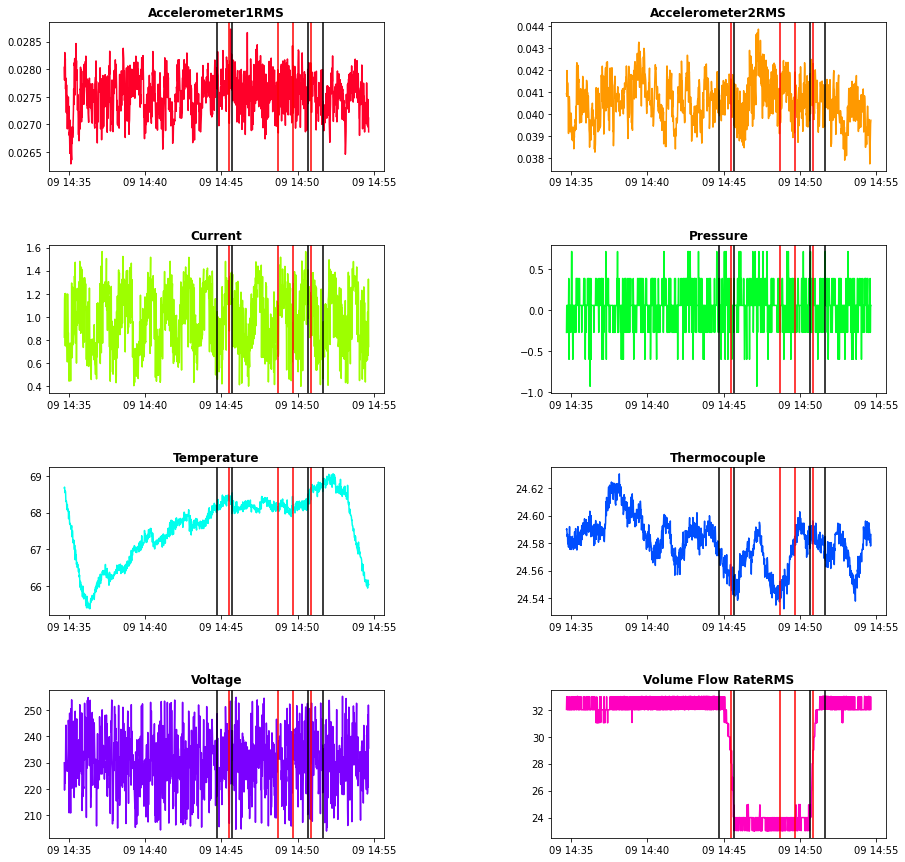

In [19]:
# Plot Anomalies
for i in experiments:
    print(all_files[i].replace("/","\\"))
    display(dfs[i].describe())
    df = dfs[i]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    color = iter(cm.gist_rainbow(np.linspace(0, 1, len(df.columns)-2)))
    points = df.index[df['changepoint'] == 1].tolist()
    preds = dfs_stand[i].index[dfs_stand[i]['Predictions'] == 1].tolist()
    for col, ax in zip(df.columns[0:8], axes.flatten()):
        c = next(color)
        ax.set_title(col, fontweight="bold")
        ax.plot(df[col], c=c)
        for p in points:
            ax.axvline(p, color="black")
        for i in preds:
            ax.axvline(i, color="red")
        plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.set_facecolor('white')
    fig.set_size_inches(15, 15)

In [20]:
# Evaluate Change Point Predictions

# Use the following code when adjusting the changepoint detection windows:
# importlib.reload(utils.evaluating)
# from utils.evaluating import evaluating_change_point

with HiddenPrints():
    print('Experiment 1')
    score = evaluating_change_point(dfs[1]['changepoint'], dfs_stand[1]['Predictions'], metric='nab')
    scores = pd.DataFrame([score.values()], columns=['Standard', 'LowFP', 'LowFN'])
    scores.index += 1


    for idx, df in enumerate(dfs_stand[2:], 2):
        print(f'Experiment {idx}')
        score = evaluating_change_point(dfs[idx]['changepoint'], df['Predictions'], metric='nab')
        scores.loc[idx] = score.values()


print(scores)

    Standard  LowFP  LowFN
1      20.87  16.75  22.25
2      73.61  72.24  74.08
3      22.25  19.50  23.17
4      47.25  44.50  48.17
5      20.87  16.75  22.25
6       0.00   0.00   0.00
7      -1.38  -2.75  -0.92
8      -4.13  -8.25  -2.75
9       0.00   0.00   0.00
10     21.87  19.08  22.91
11     -1.38  -2.75  -0.92
12     -5.50 -11.00  -3.67
13     31.38  29.53  32.03
14     -5.50 -11.00  -3.67
15     -2.75  -5.50  -1.83
16     -1.38  -2.75  -0.92
17     -2.75  -5.50  -1.83
18     22.87  21.42  23.58
19     50.00  50.00  50.00
20     25.00  25.00  25.00
21     -4.13  -8.25  -2.75
22     23.62  22.25  24.08
23     -7.33 -14.67  -4.89
24     -4.13  -8.25  -2.75
25     22.24  19.49  23.16
26     33.46  28.10  38.97
27     -2.75  -5.50  -1.83
28     22.25  19.50  23.17
29     -2.75  -5.50  -1.83
30     -2.75  -5.50  -1.83
31     20.87  16.75  22.25
32     23.62  22.25  24.08
33     -4.13  -8.25  -2.75
34     22.25  19.50  23.17


In [21]:
test = scores['Standard'].mean()
print(test)

13.280588235294118
